In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

In [102]:
df = pd.read_csv("dataset_mood_smartphone.csv")

df.columns

Index(['Unnamed: 0', 'id', 'time', 'variable', 'value'], dtype='object')

In [103]:
# See whether all time strings are of the same length
out = df['time'].str.len().agg(['min','max'])
print (out)


min    23
max    23
Name: time, dtype: int64


In [104]:
print(df['time'][0])

2014-02-26 13:00:00.000


In [105]:
# Add a column of the day to the df
df['day'] = df['time'].str.replace("-", "")
df['day'] = df['day'].str[:-13].astype(int)


In [106]:
df['timestamps'] = pd.to_datetime(df['time'])
df['timestamps'] = df['timestamps'].dt.date

In [107]:
out = df['id'].str.len().agg(['min','max'])
print (out)

min    7
max    7
Name: id, dtype: int64


In [108]:
print(df.values[0])

[1 'AS14.01' '2014-02-26 13:00:00.000' 'mood' 6.0 20140226
 datetime.date(2014, 2, 26)]


In [109]:
df['id_time'] = df['id'].str[5:] + df['day'].astype(str)

In [110]:
df['id_time'] = df['id_time'].astype('int64')

In [111]:
print(df['timestamps'][4342])

2014-05-30


In [112]:
df['next_day'] = df['timestamps'] + pd.Timedelta(days=1)
print(df['next_day'][4342])


2014-05-31


In [113]:
variables_list = df['variable'].unique()

In [114]:
for var in variables_list:
    # Assuming df is your DataFrame and you're focusing on 'screen' values
    screen_values = df[df['variable'] == var]['value']

    # Calculate Q1, Q3, and IQR
    Q1 = screen_values.quantile(0.05)
    Q3 = screen_values.quantile(0.95)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR

    # Filter out outliers
    filtered_screen_values = screen_values[(screen_values >= lower_bound) & (screen_values <= upper_bound)]

    # You can also choose to filter the original DataFrame directly to keep rows without outliers
    df = df[(df['variable'] != var) | ((df['variable'] == var) & (df['value'] >= lower_bound) & (df['value'] <= upper_bound))]

In [115]:
# Pivot the DataFrame to have 'variable' values as columns, and then calculate sum and count for each 'id'
pivot_df = df.pivot_table(index='id_time', columns='variable', values='value', aggfunc=['mean', 'count']).reset_index()
# Rename the columns to remove the multi-index
pivot_df.columns = [f"{var}{agg}" for var, agg in pivot_df.columns]

pivot_df.fillna(0)

,id_time,meanactivity,meanappCat.builtin,meanappCat.communication,meanappCat.entertainment,meanappCat.finance,meanappCat.game,meanappCat.office,meanappCat.other,meanappCat.social,...,countappCat.travel,countappCat.unknown,countappCat.utilities,countappCat.weather,countcall,countcircumplex.arousal,countcircumplex.valence,countmood,countscreen,countsms
0,120140217,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1,120140218,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,120140219,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,2.0
3,120140220,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0
4,120140221,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,3320140527,0.012704,5.004143,59.382943,62.347000,0.0,0.0,0.000,17.835750,50.259100,...,0.0,0.0,3.0,0.0,1.0,5.0,5.0,5.0,36.0,2.0
1969,3320140528,0.103301,7.718042,37.238750,43.907571,0.0,0.0,21.254,27.891895,83.892094,...,0.0,0.0,6.0,0.0,10.0,5.0,5.0,5.0,122.0,1.0
1970,3320140529,0.169354,6.452161,54.388125,68.369000,0.0,0.0,0.000,9.734000,198.880222,...,1.0,0.0,2.0,0.0,5.0,3.0,3.0,3.0,28.0,1.0
1971,3320140530,0.192901,11.251162,46.412278,37.174286,0.0,0.0,0.000,10.522000,75.390690,...,28.0,3.0,15.0,0.0,4.0,5.0,5.0,5.0,109.0,0.0


In [116]:
for column in pivot_df.columns:
    pivot_df[column] = pivot_df[column].apply(lambda x: 0 if np.isnan(x) else x)

In [117]:
merged_df = pd.merge_asof(pivot_df.sort_values('id_time'), df.sort_values('id_time'), on='id_time', suffixes=('_old', '_new'))

In [118]:
merged_df.drop(columns=['next_day','Unnamed: 0','time'], inplace=True)

In [119]:
zeros_count = (pivot_df['meanmood'] == 0).sum()
print("Number of zeros:", zeros_count)

Number of zeros: 705


In [120]:
print(merged_df.columns)

Index(['id_time', 'meanactivity', 'meanappCat.builtin',
       'meanappCat.communication', 'meanappCat.entertainment',
       'meanappCat.finance', 'meanappCat.game', 'meanappCat.office',
       'meanappCat.other', 'meanappCat.social', 'meanappCat.travel',
       'meanappCat.unknown', 'meanappCat.utilities', 'meanappCat.weather',
       'meancall', 'meancircumplex.arousal', 'meancircumplex.valence',
       'meanmood', 'meanscreen', 'meansms', 'countactivity',
       'countappCat.builtin', 'countappCat.communication',
       'countappCat.entertainment', 'countappCat.finance', 'countappCat.game',
       'countappCat.office', 'countappCat.other', 'countappCat.social',
       'countappCat.travel', 'countappCat.unknown', 'countappCat.utilities',
       'countappCat.weather', 'countcall', 'countcircumplex.arousal',
       'countcircumplex.valence', 'countmood', 'countscreen', 'countsms', 'id',
       'variable', 'value', 'day', 'timestamps'],
      dtype='object')


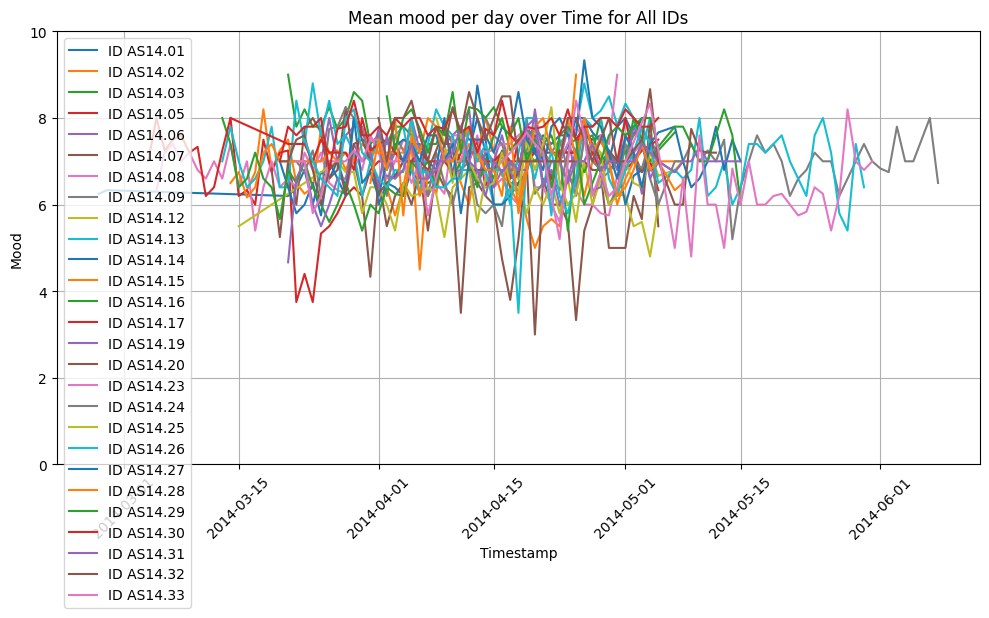

In [121]:

# Get unique IDs
unique_ids = merged_df['id'].unique()

# Plot moods for all IDs
plt.figure(figsize=(10, 6))
for id_to_plot in unique_ids:
    filtered_df = merged_df[merged_df['id'] == id_to_plot]

    # Do not plot the days on which no results were entered, zero values.
    filtered_df = filtered_df[filtered_df['meanmood'] > 0]
    plt.plot(filtered_df['timestamps'], filtered_df['meanmood'], label='ID {}'.format(id_to_plot))

plt.title('Mean mood per day over Time for All IDs')
plt.xlabel('Timestamp')
plt.ylabel('Mood')
plt.ylim(0, 10)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [122]:
merged_df['next_day'] = merged_df['timestamps'] + pd.DateOffset(days=1)

# Convert timestamps to datetime objects
merged_df['timestamps'] = pd.to_datetime(merged_df['timestamps'])
merged_df['next_day'] = pd.to_datetime(merged_df['next_day'])

df2 = merged_df.copy()


In [123]:
df2 = df2[['id', 'next_day', 'meanmood']]
df2 = df2.rename(columns={'meanmood': 'meanmood2'})
df2 = df2.rename(columns={'id': 'id2'})

In [124]:
print(df2.values[0])

['AS14.01' Timestamp('2014-02-18 00:00:00') 0.0]


In [125]:
merged_df = pd.merge(df2, merged_df, left_on='next_day', right_on='timestamps', how='left')
merged_df['y'] = merged_df['meanmood2'].fillna(0)


In [126]:
labeled_df = merged_df[merged_df['y'] > 0]
labeled_df = labeled_df[merged_df['id'] == merged_df['id2']]

C:\Users\tomsl\AppData\Local\Temp\ipykernel_21680\2300971913.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  labeled_df = labeled_df[merged_df['id'] == merged_df['id2']]


In [127]:
print(labeled_df.values[0])
print(labeled_df.columns)

['AS14.01' Timestamp('2014-02-27 00:00:00') 6.25 120140227.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3333333333333333
 6.333333333333333 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 3.0 3.0 3.0 0.0 0.0 'AS14.01' 'circumplex.arousal' 1.0 20140227.0
 Timestamp('2014-02-27 00:00:00') Timestamp('2014-02-28 00:00:00') 6.25]
Index(['id2', 'next_day_x', 'meanmood2', 'id_time', 'meanactivity',
       'meanappCat.builtin', 'meanappCat.communication',
       'meanappCat.entertainment', 'meanappCat.finance', 'meanappCat.game',
       'meanappCat.office', 'meanappCat.other', 'meanappCat.social',
       'meanappCat.travel', 'meanappCat.unknown', 'meanappCat.utilities',
       'meanappCat.weather', 'meancall', 'meancircumplex.arousal',
       'meancircumplex.valence', 'meanmood', 'meanscreen', 'meansms',
       'countactivity', 'countappCat.builtin', 'countappCat.communication',
       'countappCat.entertainment', 'countappCat.finance', 'countappCat.game',


In [128]:
labeled_df[['meanmood', 'meanmood2', 'y']]

,meanmood,meanmood2,y
135,6.333333,6.250000,6.250000
156,0.000000,6.333333,6.333333
532,6.400000,6.200000,6.200000
553,6.800000,6.400000,6.400000
576,6.000000,6.800000,6.800000
...,...,...,...
44298,6.200000,5.400000,5.400000
44301,8.200000,6.200000,6.200000
44304,7.000000,8.200000,8.200000
44307,6.800000,7.000000,7.000000


In [129]:
columns_to_drop = ['meanmood2', 'next_day_x', 'id2', 'id_time', 'day', 'value', 'variable', 'next_day_y', 'id', 'timestamps']
labeled_df = labeled_df.drop(columns=columns_to_drop)

In [130]:
print(labeled_df.shape)

print(labeled_df['y'])
print(labeled_df.columns)

(1245, 39)
135      6.250000
156      6.333333
532      6.200000
553      6.400000
576      6.800000
           ...   
44298    5.400000
44301    6.200000
44304    8.200000
44307    7.000000
44309    6.800000
Name: y, Length: 1245, dtype: float64
Index(['meanactivity', 'meanappCat.builtin', 'meanappCat.communication',
       'meanappCat.entertainment', 'meanappCat.finance', 'meanappCat.game',
       'meanappCat.office', 'meanappCat.other', 'meanappCat.social',
       'meanappCat.travel', 'meanappCat.unknown', 'meanappCat.utilities',
       'meanappCat.weather', 'meancall', 'meancircumplex.arousal',
       'meancircumplex.valence', 'meanmood', 'meanscreen', 'meansms',
       'countactivity', 'countappCat.builtin', 'countappCat.communication',
       'countappCat.entertainment', 'countappCat.finance', 'countappCat.game',
       'countappCat.office', 'countappCat.other', 'countappCat.social',
       'countappCat.travel', 'countappCat.unknown', 'countappCat.utilities',
       'countappCat.

In [131]:
# Min-max scaling function to normalize values between -1 and 1
def normalize_numeric(x):
    if x.dtype in ['int64', 'float64']:  # Check if column contains numeric values
        return (x - x.min()) / (x.max() - x.min()) * 2 -1
    else:
        return x

# Apply min-max scaling to every column
normalized_df = labeled_df.apply(normalize_numeric)

In [132]:
normalized_df['y']

135      0.026316
156      0.052632
532      0.010526
553      0.073684
576      0.200000
           ...   
44298   -0.242105
44301    0.010526
44304    0.642105
44307    0.263158
44309    0.200000
Name: y, Length: 1245, dtype: float64

In [133]:
normalized_df['y'] = normalized_df['y'].round(decimals=1)

In [134]:
normalized_df['y'] = labeled_df['y'].round()

In [145]:
normalized_df['y'].shape

(1245,)

In [136]:
from sklearn.model_selection import train_test_split

# Splitting the data into train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# First, split into train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(normalized_df[['meanactivity', 'meanappCat.builtin', 'meanappCat.communication',
       'meanappCat.entertainment', 'meanappCat.finance', 'meanappCat.game',
       'meanappCat.office', 'meanappCat.other', 'meanappCat.social',
       'meanappCat.travel', 'meanappCat.unknown', 'meanappCat.utilities',
       'meanappCat.weather', 'meancall', 'meancircumplex.arousal',
       'meancircumplex.valence', 'meanscreen', 'meansms',
       'countactivity', 'countappCat.builtin', 'countappCat.communication',
       'countappCat.entertainment', 'countappCat.finance', 'countappCat.game',
       'countappCat.office', 'countappCat.other', 'countappCat.social',
       'countappCat.travel', 'countappCat.unknown', 'countappCat.utilities',
       'countappCat.weather', 'countcall', 'countcircumplex.arousal',
       'countcircumplex.valence', 'countmood', 'countscreen', 'countsms']], (normalized_df['y']*0.1), test_size=test_ratio, random_state=42)

# Then, split train into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)

# Display the shape of each set
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (871, 38)
Validation set shape: (187, 38)
Test set shape: (187, 38)


In [137]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.layers import Dropout


# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

input_size = X_train.shape[1]

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(input_size,), kernel_initializer=HeUniform()),
    Dropout(0.25),
    Dense(64, activation='relu', kernel_initializer=HeUniform()),
    Dropout(0.25),
    Dense(32, activation='relu', kernel_initializer=HeUniform()),
    Dropout(0.25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=20, verbose=1)

Epoch 1/100


44/44 [==============================] - 2s 5ms/step - loss: 1.1536
Epoch 2/100
44/44 [==============================] - 0s 4ms/step - loss: 0.4609
Epoch 3/100
44/44 [==============================] - 0s 4ms/step - loss: 0.2682
Epoch 4/100
44/44 [==============================] - 0s 4ms/step - loss: 0.1860
Epoch 5/100
44/44 [==============================] - 0s 4ms/step - loss: 0.1263
Epoch 6/100
44/44 [==============================] - 0s 4ms/step - loss: 0.1077
Epoch 7/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0900
Epoch 8/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0910
Epoch 9/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0677
Epoch 10/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0574
Epoch 11/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0585
Epoch 12/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0525
Epoch 13/100
44/44 [=============================

In [138]:
# Predict on test data
predictions = model.predict(X_test)

# Print the predictions
print("Predictions:", predictions.flatten())

# Optionally, you can compare the predictions with the actual values
print("Actual values:", y_test)

6/6 [==============================] - 0s 4ms/step
Predictions: [0.6910699  0.7163928  0.6877425  0.69413084 0.705239   0.67059094
 0.68492115 0.6818508  0.68333954 0.6794577  0.6895862  0.68463176
 0.69317335 0.7114909  0.6987588  0.6963595  0.6986464  0.66732496
 0.67818123 0.6843907  0.7057216  0.70494807 0.72277206 0.6966793
 0.67856926 0.68911326 0.7167402  0.7049935  0.7104794  0.6768991
 0.730217   0.70256245 0.7004562  0.69536394 0.70776546 0.69556737
 0.68738025 0.69771314 0.67609656 0.70085055 0.664364   0.6639247
 0.69233114 0.6952807  0.69673175 0.67864287 0.6730995  0.69466335
 0.6897934  0.70345074 0.68627435 0.7075362  0.709955   0.6709749
 0.6757839  0.680258   0.67483956 0.69498765 0.70366675 0.677846
 0.6821295  0.677346   0.6846189  0.7043255  0.69489884 0.69884354
 0.69714063 0.69635385 0.69153976 0.6902084  0.69541144 0.69003916
 0.72095466 0.68839216 0.6692795  0.6874356  0.69704247 0.6772341
 0.69962835 0.6901774  0.68775463 0.67006993 0.69567627 0.6948662
 0.696

In [139]:
def acc(pred, y):
    preds = pred.flatten()
    total_y = len(y)
    count = 0
    for idx,i in enumerate(y):
        pred_new = np.round(preds[idx]*10)
        y_new = np.round(i*10)
        if pred_new == y_new:
            count +=1
    return count / total_y
    
print("Test accuracy: ", acc(predictions, y_test))

Test accuracy:  0.5133689839572193


In [140]:
from sklearn.model_selection import train_test_split

# Splitting the data into train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15



# First, split into train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(normalized_df[['meanactivity', 'meanappCat.builtin', 'meanappCat.communication',
       'meanappCat.entertainment', 'meanappCat.finance', 'meanappCat.game',
       'meanappCat.office', 'meanappCat.other', 'meanappCat.social',
       'meanappCat.travel', 'meanappCat.unknown', 'meanappCat.utilities',
       'meanappCat.weather', 'meancall', 'meancircumplex.arousal',
       'meancircumplex.valence', 'meanscreen', 'meansms',
       'countactivity', 'countappCat.builtin', 'countappCat.communication',
       'countappCat.entertainment', 'countappCat.finance', 'countappCat.game',
       'countappCat.office', 'countappCat.other', 'countappCat.social',
       'countappCat.travel', 'countappCat.unknown', 'countappCat.utilities',
       'countappCat.weather', 'countcall', 'countcircumplex.arousal',
       'countcircumplex.valence', 'countmood', 'countscreen', 'countsms', 'meanmood']], (normalized_df['y']).round(0), test_size=test_ratio, random_state=42)

# Then, split train into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)

# Display the shape of each set
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (871, 38)
Validation set shape: (187, 38)
Test set shape: (187, 38)


In [141]:
print(normalized_df['y'].min())
print(normalized_df['y'].max())

3.0
9.0


In [142]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import metrics





# Define the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')  # Output layer with 10 units for 10 classes and softmax activation
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


Epoch 1/100
25/25 [==============================] - 3s 31ms/step - loss: 1.9669 - accuracy: 0.3423 - val_loss: 1.4844 - val_accuracy: 0.4091
Epoch 2/100
25/25 [==============================] - 0s 11ms/step - loss: 1.3772 - accuracy: 0.4623 - val_loss: 1.2913 - val_accuracy: 0.4091
Epoch 3/100
25/25 [==============================] - 0s 8ms/step - loss: 1.3342 - accuracy: 0.4240 - val_loss: 1.2806 - val_accuracy: 0.4091
Epoch 4/100
25/25 [==============================] - 0s 8ms/step - loss: 1.2629 - accuracy: 0.4955 - val_loss: 1.1991 - val_accuracy: 0.4091
Epoch 5/100
25/25 [==============================] - 0s 8ms/step - loss: 1.2527 - accuracy: 0.4840 - val_loss: 1.1907 - val_accuracy: 0.4091
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 1.2325 - accuracy: 0.4751 - val_loss: 1.2236 - val_accuracy: 0.4091
Epoch 7/100
25/25 [==============================] - 0s 8ms/step - loss: 1.2208 - accuracy: 0.5057 - val_loss: 1.1917 - val_accuracy: 0.4091
Epoch 8/100

In [143]:
# Train a decision tree

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Define the decision tree classifier
tree_clf = DecisionTreeClassifier(random_state=42)

# Train the decision tree classifier
tree_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = tree_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy:', accuracy)

Test accuracy: 0.48128342245989303


In [144]:
# Train an SVM

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Define the multiclass SVM classifier
svm_clf = SVC(kernel='poly', decision_function_shape='ovr')  # One-vs-Rest (OvR) strategy for multiclass classification

# Train the SVM classifier
svm_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy:', accuracy)


Test accuracy: 0.5454545454545454
